# Test comment similarity among readers
Do readers of similar groups (location, experience, engagement) tend to react similarity with respect to the same article?

We look at this in terms of:

- entity mentions
- question content

## Load data

First, load author comment data extracted from prior comments, e.g. location.

In [1]:
import pandas as pd
from datetime import datetime
comment_author_data = pd.read_csv('../../data/nyt_comments/author_comment_social_data.tsv', sep='\t', index_col=False)
date_day_fmt = '%Y-%m-%d'
comment_author_data = comment_author_data.assign(**{
    'date_day' : comment_author_data.loc[:, 'date_day'].apply(lambda x: datetime.strptime(x, date_day_fmt))
})
display(comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region
0,1045,2017-04-09,1,0,US
1,1045,2018-01-17,0,0,US
2,1045,2018-01-24,0,0,US
3,1072,2017-03-13,1,1,US
4,1072,2018-01-03,0,1,US


In [3]:
## load comments
import os
month_year_pairs = [
        ('Jan', '2017'),
        ('Feb', '2017'),
        ('March', '2017'),
        ('April', '2017'),
        ('Jan', '2018'),
        ('Feb', '2018'),
        ('March', '2018'),
        ('April', '2018'),
    ]
comment_data_dir = '../../data/nyt_comments/'
comment_cols = ['articleID', 'commentBody', 'createDate', 'userID']
comment_data_files = list(map(lambda x: os.path.join(comment_data_dir, f'Comments{x[0]}{x[1]}.csv'), month_year_pairs))
comment_data = list(map(lambda x: pd.read_csv(x, sep=',', index_col=False, usecols=comment_cols), comment_data_files))
comment_data = pd.concat(comment_data, axis=0)
comment_data = comment_data.assign(**{
    'userID' : comment_data.loc[:, 'userID'].astype(int)
})
# remove null comments
comment_data = comment_data[comment_data.loc[:, 'commentBody'].apply(lambda x: type(x) is not float)]
# fix date var
from data_helpers import round_date_to_day
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(round_date_to_day)
})
display(comment_data.head())

<ipython-input-3-61d679fddff7>:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


,articleID,commentBody,createDate,userID,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,1.483426e+09,64679318,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,1.483417e+09,69254188,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,1.483431e+09,76788711,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,1.483419e+09,72718862,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,1.483417e+09,7529267,2017-01-02


In [4]:
## join data
combined_comment_author_data = pd.merge(comment_author_data, comment_data, on=['userID', 'date_day'])
print(f'{combined_comment_author_data.shape[0]} comments')
display(combined_comment_author_data.head())

1899592 comments


,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate
0,1045,2017-04-09,1,0,US,58e3609a7c459f24986d83a6,"The ""earliest days of the internet"" were not i...",1.491756e+09
1,1045,2018-01-17,0,0,US,5a5f71d87c459f29e79b46ad,You left out the part where she wrote an anony...,1.516227e+09
2,1045,2018-01-24,0,0,US,5a68592710f40f00018bd70d,"Yes, thank you. Folks need to lighten up. I wo...",1.516816e+09
3,1072,2017-03-13,1,1,US,58c7001c7c459f247805b940,“Try to imagine a … presidential candidate say...,1.489449e+09
4,1072,2018-01-03,0,1,US,5a4e75be7c459f29e79b20c2,Fix the Subways. That this argument has to be...,1.514982e+09


## Test entity overlap
First, let's test the overlap in entities mentioned in the comments, without respect to the article.

In [5]:
## extract entities with NER
import stanza
# help(stanza.Pipeline)
nlp_pipeline = stanza.Pipeline(lang='en', processors='tokenize,ner', use_gpu=True)

2020-12-19 23:44:21 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2020-12-19 23:44:21 INFO: Use device: gpu
2020-12-19 23:44:21 INFO: Loading: tokenize
2020-12-19 23:44:24 INFO: Loading: ner
2020-12-19 23:44:25 INFO: Done loading processors!


In [6]:
def extract_all_named_entities(text, pipeline):
    text_doc = pipeline(text)
    named_entities = []
    for text_sent_i in text_doc.sentences:
        NE_tokens_i = []
        for token_j in text_sent_i.tokens:
            token_j_NE = token_j.ner
            if(token_j_NE != 'O'):
                token_j_text = token_j.text
                if(token_j_NE.startswith('E')):
                    NE_tokens_i.append(token_j_text)
                    NE_final = '_'.join(NE_tokens_i)
                    named_entities.append(NE_final)
                    NE_tokens_i = []
                else:
                    NE_tokens_i.append(token_j_text)
    return named_entities
# print(nlp_pipeline('this is a test for Donald Trump. he is a person.'))
test_text = 'this is a test for Donald Trump. he is a person. the Atlanta Falcons won the game.'
x = nlp_pipeline(test_text)
# print(x.)
print(extract_all_named_entities(test_text, nlp_pipeline))

['Donald_Trump', 'the_Atlanta_Falcons']


Let's sample to avoid hurting our memory.

In [7]:
import numpy as np
np.random.seed(123)
sample_size = 100000
sample_comment_author_data_idx = np.random.choice(combined_comment_author_data.index, sample_size, replace=False)
sample_comment_author_data = combined_comment_author_data.loc[sample_comment_author_data_idx, :]

In [8]:
from tqdm import tqdm
tqdm.pandas()
sample_comment_author_data = sample_comment_author_data.assign(**{
    'named_entities' : sample_comment_author_data.loc[:, 'commentBody'].progress_apply(lambda x: extract_all_named_entities(x, nlp_pipeline))
})

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 10%|▉         | 9526/100000 [10:24<1:24:26, 17.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 41%|████      | 40795/100000 [42:21<55:11, 17.88it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (s

In [9]:
display(sample_comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,named_entities
438434,30569608,2017-01-23,0,0,US,5885282895d0e0392607c266,Just watched Sean Splicer's news briefing. He ...,1.485213e+09,[Sean_Splicer_'s]
201060,12698735,2017-01-18,1,1,non_US,587e66d195d0e0392607b2ee,Glad to hear I'm not the only one who cries at...,1.484776e+09,[Chef_Howard]
66777,2258463,2018-03-24,1,1,US,5ab6993247de81a901216a6a,"Perhaps a better analogy: Hiroshima, destructi...",1.521944e+09,[]
1215272,63735584,2017-04-05,0,0,US,58de28ac7c459f24986d7a00,"I am losing weight, slowly, at the age of 64 f...",1.491395e+09,[the_age_of_64]
1579567,71835948,2017-02-05,0,0,non_US,58962bcf95d0e0392607ea60,"How does an ""originalist"" ever get to Brown v....",1.486312e+09,[Brown_v._Board_of_Education]


In [11]:
## write to file temporarily, then restart kernel to fix memory
sample_comment_author_data.to_csv('../../data/nyt_comments/sample_author_comment_entities.gz', sep='\t', compression='gzip', index=False)

In [1]:
import pandas as pd
sample_comment_author_data = pd.read_csv('../../data/nyt_comments/sample_author_comment_entities.gz', sep='\t', compression='gzip', index_col=False)

In [2]:
from ast import literal_eval
sample_comment_author_data = sample_comment_author_data.assign(**{
    'NE_list' : sample_comment_author_data.loc[:, 'named_entities'].apply(literal_eval)
})
display(sample_comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,named_entities,NE_list
0,30569608,2017-01-23,0,0,US,5885282895d0e0392607c266,Just watched Sean Splicer's news briefing. He ...,1.485213e+09,"[""Sean_Splicer_'s""]",[Sean_Splicer_'s]
1,12698735,2017-01-18,1,1,non_US,587e66d195d0e0392607b2ee,Glad to hear I'm not the only one who cries at...,1.484776e+09,['Chef_Howard'],[Chef_Howard]
2,2258463,2018-03-24,1,1,US,5ab6993247de81a901216a6a,"Perhaps a better analogy: Hiroshima, destructi...",1.521944e+09,[],[]
3,63735584,2017-04-05,0,0,US,58de28ac7c459f24986d7a00,"I am losing weight, slowly, at the age of 64 f...",1.491395e+09,['the_age_of_64'],[the_age_of_64]
4,71835948,2017-02-05,0,0,non_US,58962bcf95d0e0392607ea60,"How does an ""originalist"" ever get to Brown v....",1.486312e+09,['Brown_v._Board_of_Education'],[Brown_v._Board_of_Education]


In [3]:
## clean up NEs
import re
POSS_MATCHER = re.compile("_'s$") # possessive
ARTICLE_MATCHER = re.compile('^(the|a|an)_') # article
def clean_NE(NE):
    NE = POSS_MATCHER.sub('', NE)
    NE = ARTICLE_MATCHER.sub('', NE)
    return NE
sample_comment_author_data = sample_comment_author_data.assign(**{
    'NE_list' : sample_comment_author_data.loc[:, 'NE_list'].apply(lambda x: list(map(lambda y: clean_NE(y), x)))
})

In [4]:
## count most frequent NEs
sample_NEs = []
for NE_i in sample_comment_author_data.loc[:, 'NE_list'].values:
    sample_NEs.extend(NE_i)
sample_NEs = pd.Series(sample_NEs).value_counts()
print(sample_NEs.head(10))

Donald_Trump        1518
White_House         1106
United_States        979
Paul_Ryan            469
Hillary_Clinton      432
North_Korea          406
Supreme_Court        402
New_York             340
Republican_Party     328
NY_Times             314
dtype: int64


Do people in the same reader group tend to mention the same entities in response to the same article?

We'll compare the entity overlap among reader groups (aggregate) versus entity overlap among randomly-grouped people.

Later: we'll compare at the level of news sections to address topical effects.

In [52]:
from functools import reduce
import numpy as np
from scipy.spatial.distance import cosine
def compute_NE_dist(NE_list_1, NE_list_2):
    """
    Compute distance between NE lists based on
    frequency difference.
    """
    NE_counts_1 = pd.Series(list(reduce(lambda x,y: x+y, NE_list_1))).value_counts()
    NE_counts_2 = pd.Series(list(reduce(lambda x,y: x+y, NE_list_2))).value_counts()
    # default value (no NEs) => -1
    if(len(NE_counts_1) == 0 and len(NE_counts_2) == 0):
        return np.nan
    else:
        # combine index
        NE_combined = list(set(NE_counts_1.index) | set(NE_counts_2.index))
        NE_counts_1 = NE_counts_1.reindex(NE_combined, fill_value=0.)
        NE_counts_2 = NE_counts_2.reindex(NE_combined, fill_value=0.)
        # normalize
        NE_counts_1 = (NE_counts_1 / NE_counts_1.sum()).fillna(0.)
        NE_counts_2 = (NE_counts_2 / NE_counts_2.sum()).fillna(0.)
#         print(NE_counts_1)
#         print(NE_counts_2)
        # compute difference
#         NE_count_diff = NE_counts_1 - NE_counts_2
#         NE_count_diff = (NE_count_diff**2.).sum()**.5
        NE_count_diff = cosine(NE_counts_1, NE_counts_2)
        return NE_count_diff

In [60]:
from scipy.stats import mannwhitneyu
import numpy as np
np.random.seed(123)
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
pair_sample_size = 1000
for author_group_var_i in author_group_vars:
    author_group_vals_i = set(sample_comment_author_data.loc[:, author_group_var_i].unique())
    ## compute paired similarity
    paired_diffs = []
    unpaired_diffs = []
    for author_group_val_j, data_j in sample_comment_author_data.groupby(author_group_var_i):
        print(f'testing var={author_group_var_i} for value={author_group_val_j}')
        # randomly sample N author pairs
        authors_j = data_j.loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, 2, replace=False)
            author_1_k, author_2_k = authors_k
            data_1_k = data_j[data_j.loc[:, 'userID']==author_1_k]
            data_2_k = data_j[data_j.loc[:, 'userID']==author_2_k]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
#             if(np.isnan(NE_count_diff_k)):
#                 print(f'nan value for NEs 1 = {NE_1_k}; NEs 2 = {NE_2_k}')
#                 break
            paired_diffs.append(NE_count_diff_k)
        ## compute randomly-paired similarity
        other_authors_j = sample_comment_author_data[~sample_comment_author_data.loc[:, 'userID'].isin(authors_j)].loc[:, 'userID'].unique()
        # get pair from both groups, compute difference
        np.random.shuffle(authors_j)
        np.random.shuffle(other_authors_j)
        for group_author_k, other_group_author_k in zip(authors_j[:pair_sample_size], other_authors_j):
            data_1_k = data_j[data_j.loc[:, 'userID']==group_author_k]
            data_2_k = sample_comment_author_data[sample_comment_author_data.loc[:, 'userID']==other_group_author_k]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            unpaired_diffs.append(NE_count_diff_k)
    ## compare
    paired_diffs = np.array(paired_diffs)
    unpaired_diffs = np.array(unpaired_diffs)
    paired_diffs = paired_diffs[~np.isnan(paired_diffs)]
    unpaired_diffs = unpaired_diffs[~np.isnan(unpaired_diffs)]
    print('mean paired diff = %.3E'%(np.mean(paired_diffs)))
    print('mean unpaired diff = %.3E'%(np.mean(unpaired_diffs)))
    test_stat, p_val = mannwhitneyu(paired_diffs, unpaired_diffs)
    print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

testing var=prior_comment_count_bin for value=0
testing var=prior_comment_count_bin for value=1
mean paired diff = 9.976E-01
mean unpaired diff = 9.992E-01
test stat = 214574.000 (p=2.221E-01)
testing var=prior_comment_len_bin for value=0
testing var=prior_comment_len_bin for value=1
mean paired diff = 9.985E-01
mean unpaired diff = 9.985E-01
test stat = 246251.000 (p=2.897E-01)
testing var=location_region for value=US
testing var=location_region for value=non_US
mean paired diff = 9.978E-01
mean unpaired diff = 9.982E-01
test stat = 241871.000 (p=3.963E-01)


Not great! We see a very small difference in means for prior comment counts and for location, but not significant.

This is likely a data sparsity issue, since most of the authors only write one comment.
Let's try to scale this up:

- for each author group, sample $M_1$ authors and $M_2$ authors, then compute their NE similarity
- for each author group, sample $M_1$ authors in-group and $M_2$ authors out-of-group, then compute their NE similarity

In [71]:
from scipy.stats import mannwhitneyu
import numpy as np
np.random.seed(123)
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
pair_sample_size = 1000
group_sample_size = 200
combined_diff_data = []
for author_group_var_i in author_group_vars:
    author_group_vals_i = set(sample_comment_author_data.loc[:, author_group_var_i].unique())
    ## compute paired similarity
    paired_diffs = []
    unpaired_diffs = []
    for author_group_val_j, data_j in sample_comment_author_data.groupby(author_group_var_i):
        print(f'testing var={author_group_var_i} for value={author_group_val_j}')
        # randomly sample N author pairs
        authors_j = data_j.loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, 2, replace=False)
            author_1_k = np.random.choice(authors_j, group_sample_size, replace=False)
            author_2_k_pool = list(set(authors_j) - set(author_1_k))
            author_2_k = np.random.choice(author_2_k_pool, min(group_sample_size, len(author_2_k_pool)), replace=False)
            data_1_k = data_j[data_j.loc[:, 'userID'].isin(author_1_k)]
            data_2_k = data_j[data_j.loc[:, 'userID'].isin(author_2_k)]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            paired_diffs.append(NE_count_diff_k)
        ## compute randomly-paired similarity
        other_authors_j = sample_comment_author_data[~sample_comment_author_data.loc[:, 'userID'].isin(authors_j)].loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, group_sample_size, replace=False)
            other_authors_k = np.random.choice(other_authors_j, group_sample_size, replace=False)
            data_1_k = data_j[data_j.loc[:, 'userID'].isin(authors_k)]
            data_2_k = sample_comment_author_data[sample_comment_author_data.loc[:, 'userID'].isin(other_authors_k)]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            unpaired_diffs.append(NE_count_diff_k)
    ## compare
    paired_diffs = np.array(paired_diffs)
    unpaired_diffs = np.array(unpaired_diffs)
    paired_diffs = paired_diffs[~np.isnan(paired_diffs)]
    unpaired_diffs = unpaired_diffs[~np.isnan(unpaired_diffs)]
    print('median paired diff = %.3E'%(np.median(paired_diffs)))
    print('median unpaired diff = %.3E'%(np.median(unpaired_diffs)))
    test_stat, p_val = mannwhitneyu(paired_diffs, unpaired_diffs)
    print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))
    diff_data_i = pd.DataFrame(
        [paired_diffs, unpaired_diffs, 
         [author_group_var_i,]*(pair_sample_size*2), 
         list(range(pair_sample_size*2))],
        index=['paired_diff', 'unpaired_diff', 'author_group', 'sample']
    ).transpose()
    combined_diff_data.append(diff_data_i)
combined_diff_data = pd.concat(combined_diff_data)

testing var=prior_comment_count_bin for value=0
testing var=prior_comment_count_bin for value=1
median paired diff = 8.099E-01
median unpaired diff = 8.148E-01
test stat = 1860181.000 (p=6.443E-05)
testing var=prior_comment_len_bin for value=0
testing var=prior_comment_len_bin for value=1
median paired diff = 7.959E-01
median unpaired diff = 8.109E-01
test stat = 1837581.000 (p=4.345E-06)
testing var=location_region for value=US
testing var=location_region for value=non_US
median paired diff = 7.982E-01
median unpaired diff = 8.029E-01
test stat = 1922489.000 (p=1.690E-02)


,diff,author_group,diff_type
0,0.777923,location_region,intra-group
1,0.791526,location_region,intra-group
2,0.814428,location_region,intra-group
3,0.83328,location_region,intra-group
4,0.872686,location_region,intra-group


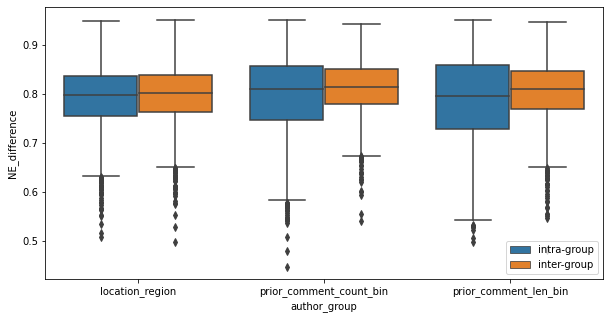

In [79]:
# ## plot differences
# # flatten data for plotting
# flat_diff_data = []
# for group_i, data_i in combined_diff_data.groupby('author_group'):
#     pair_data_i = data_i.loc[:, ['paired_diff', 'author_group']].rename(columns={'paired_diff':'diff'}).assign(**{'diff_type' : 'intra-group'})
#     unpair_data_i = data_i.loc[:, ['unpaired_diff', 'author_group']].rename(columns={'unpaired_diff':'diff'}).assign(**{'diff_type' : 'inter-group'})
#     flat_diff_data.extend([pair_data_i, unpair_data_i])
# flat_diff_data = pd.concat(flat_diff_data, axis=0)
display(flat_diff_data.head())
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.boxplot(data=flat_diff_data, x='author_group', y='diff', hue='diff_type')
plt.legend(loc='lower right')
plt.ylabel('NE_difference')
plt.show()

OK! This is more what I expected. The author groups have (slightly) lower intra-group difference than inter-group difference.

### Test question similarity
Now that we've established that readers in the same group tend to mention similar NEs, can we determine if readers in the same group ask similar questions?

For this we need a more complicated approach.
Let's look first at the type of question based on `information elicited` ("what", "where", "why", "how", "who").
For completeness, we'll also convert questions to latent semantic space and compute their similarity, in parallel with the NE comparison from before.

What kinds of questions occur most frequently, based on initial words in question?

In [2]:
## load comments
import os
import pandas as pd
month_year_pairs = [
        ('Jan', '2017'),
        ('Feb', '2017'),
        ('March', '2017'),
        ('April', '2017'),
        ('Jan', '2018'),
        ('Feb', '2018'),
        ('March', '2018'),
        ('April', '2018'),
    ]
comment_data_dir = '../../data/nyt_comments/'
comment_cols = ['articleID', 'commentBody', 'createDate', 'userID']
comment_data_files = list(map(lambda x: os.path.join(comment_data_dir, f'Comments{x[0]}{x[1]}.csv'), month_year_pairs))
comment_data = list(map(lambda x: pd.read_csv(x, sep=',', index_col=False, usecols=comment_cols), comment_data_files))
comment_data = pd.concat(comment_data, axis=0)
comment_data = comment_data.assign(**{
    'userID' : comment_data.loc[:, 'userID'].astype(int)
})
# remove null comments
comment_data = comment_data[comment_data.loc[:, 'commentBody'].apply(lambda x: type(x) is not float)]
# fix date var
from data_helpers import round_date_to_day
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(round_date_to_day)
})
display(comment_data.head())

<ipython-input-2-748e6f3f5b42>:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


,articleID,commentBody,createDate,userID,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,1.483426e+09,64679318,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,1.483417e+09,69254188,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,1.483431e+09,76788711,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,1.483419e+09,72718862,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,1.483417e+09,7529267,2017-01-02


In [5]:
## extract questions
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_questions
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
import re
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
min_question_len = 5
question_matcher = re.compile('.+\?$')
assert question_matcher.match('is this a question?')
comment_data = comment_data.assign(**{
    'comment_questions' : comment_data.loc[:, 'commentBody'].apply(lambda x: extract_questions(x, word_tokenizer, sent_tokenizer, question_matcher, min_question_len=min_question_len))
})

In [8]:
## what are the most common first words in questions?
question_start_words = []
for questions_i in comment_data.loc[:, 'comment_questions'].values:
    for question_j in questions_i:
        question_tokens_j = word_tokenizer.tokenize(question_j)
        question_start_word_j = question_tokens_j[0].lower()
        question_start_words.append(question_start_word_j)
question_start_words_count = pd.Series(question_start_words).value_counts()
display(question_start_words_count.head(50))

what        45549
how         38106
why         38030
<           26306
is          22713
and         19873
so          17340
i           15179
the         14739
if          14591
who         13477
do          13011
are         11372
where       11137
but         10745
does         9639
can          9335
or           8987
you          8637
when         8632
did          8318
will         7297
"            7151
"<           6647
it           5542
would        4778
trump        4600
a            4319
isn          4110
that         3997
have         3889
this         3815
we           3607
he           3352
in           3302
was          3208
could        3175
has          3085
maybe        2917
they         2847
as           2576
now          2542
remember     2538
should       2472
don          2368
to           2147
no           1962
perhaps      1933
just         1933
for          1794
dtype: int64

In [12]:
import re
def extract_question_type(question, word_tokenizer, question_matcher_pairs):
    question_type = 'OTHER'
    question_tokens = word_tokenizer.tokenize(question)
    question_start_token = question_tokens[0].lower()
    for question_matcher_i, question_type_i in question_matcher_pairs:
        if(question_matcher_i.match(question_start_token)):
            question_type = question_type_i
    return question_type
question_matcher_pairs = [
    (re.compile('what'), 'WHAT'),
    (re.compile('how'), 'HOW'),
    (re.compile('why'), 'WHY'),
    (re.compile('who'), 'WHO'),
    (re.compile('where'), 'WHERE'),
    (re.compile('when'), 'WHEN'),
    (re.compile('will'), 'WILL'), # "will" => future concerns
    (re.compile('can|could'), 'CAN'), # "can/could" => possibility
    (re.compile('should'), 'SHOULD'), # "should" => value enforcement
]
question_types = list(list(zip(*question_matcher_pairs))[1]) + ['OTHER']
test_question = 'who is the best leader?'
test_question_type = extract_question_type(test_question, word_tokenizer, question_matcher_pairs)
print(f'question = <{test_question}>; type = <{test_question_type}>')

question = <who is the best leader?>; type = <WHO>


In [13]:
# extract all question types
comment_data = comment_data.assign(**{
    'question_types' : comment_data.loc[:, 'comment_questions'].apply(lambda x: list(map(lambda y: extract_question_type(y, word_tokenizer, question_matcher_pairs), x)))
})

In [14]:
## get author social data
import pandas as pd
from datetime import datetime
comment_author_data = pd.read_csv('../../data/nyt_comments/author_comment_social_data.tsv', sep='\t', index_col=False)
date_day_fmt = '%Y-%m-%d'
comment_author_data = comment_author_data.assign(**{
    'date_day' : comment_author_data.loc[:, 'date_day'].apply(lambda x: datetime.strptime(x, date_day_fmt))
})
display(comment_author_data.head())
## join data
combined_comment_author_data = pd.merge(comment_author_data, comment_data, on=['userID', 'date_day'])
print(f'{combined_comment_author_data.shape[0]} comments')
display(combined_comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region
0,1045,2017-04-09,1,0,US
1,1045,2018-01-17,0,0,US
2,1045,2018-01-24,0,0,US
3,1072,2017-03-13,1,1,US
4,1072,2018-01-03,0,1,US


1899592 comments


,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,comment_questions,question_types
0,1045,2017-04-09,1,0,US,58e3609a7c459f24986d83a6,"The ""earliest days of the internet"" were not i...",1.491756e+09,[],[]
1,1045,2018-01-17,0,0,US,5a5f71d87c459f29e79b46ad,You left out the part where she wrote an anony...,1.516227e+09,"[Is that the right thing, too?]",[OTHER]
2,1045,2018-01-24,0,0,US,5a68592710f40f00018bd70d,"Yes, thank you. Folks need to lighten up. I wo...",1.516816e+09,[],[]
3,1072,2017-03-13,1,1,US,58c7001c7c459f247805b940,“Try to imagine a … presidential candidate say...,1.489449e+09,[],[]
4,1072,2018-01-03,0,1,US,5a4e75be7c459f29e79b20c2,Fix the Subways. That this argument has to be...,1.514982e+09,[],[]


Let's use a simpler evaluation.

We're only interested in P(question-type), which we can compute within each sub-group.

In [42]:
from functools import reduce
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
# compute question probability
question_type_count_data = []
for author_group_var in author_group_vars:
    for author_group_val_i, data_i in combined_comment_author_data.groupby(author_group_var):
        print(f'testing author group var={author_group_var}; val={author_group_val_i}')
        question_data_i = data_i[data_i.loc[:, 'comment_questions'].apply(lambda x: len(x) > 0)]
        # get question type counts
        # generate DTM for question type
        question_type_data_i = []
        for question_types_j in question_data_i.loc[:, 'question_types'].values:
            for question_type_k in question_types_j:
                question_type_data_i.append(question_type_k)
        question_type_data_i = pd.get_dummies(question_type_data_i)
#         print(question_type_data_i.head())
#         question_types_i = list(reduce(lambda x,y: x+y, question_data_i.loc[:, 'question_types'].values))
#         question_type_counts_i = pd.Series(question_types_i).value_counts()
#         N_questions_i = question_type_counts_i.sum()
#         question_type_probs_i = question_type_counts_i / N_questions_i
#         question_type_err_i = question_type_probs_i*(1-question_type_probs_i) / N_questions_i**.5
#         question_type_probs_i = question_type_probs_i.reindex(question_types, fill_value=0.)
#         question_type_err_i = question_type_err_i.reindex(question_types, fill_value=0.)
#         question_prob_data_i = pd.concat([question_type_probs_i, question_type_err_i], axis=1).reset_index().rename(columns={'index' : 'question_type', 0:'prob_question', 1:'prob_question_err'})
        question_type_data_i = question_type_data_i.assign(**{
            'author_group' : author_group_var,
            'author_group_val' : author_group_val_i,
        })
        question_type_count_data.append(question_type_data_i)
question_type_count_data = pd.concat(question_type_count_data, axis=0)

testing author group var=prior_comment_count_bin; val=0
testing author group var=prior_comment_count_bin; val=1
testing author group var=prior_comment_len_bin; val=0
testing author group var=prior_comment_len_bin; val=1
testing author group var=location_region; val=US
testing author group var=location_region; val=non_US


In [58]:
# flatten
flat_question_type_count_data = pd.melt(question_type_count_data, value_vars=question_types, id_vars=['author_group', 'author_group_val'], var_name='question_type', value_name='count')
display(flat_question_type_count_data.head())

,author_group,author_group_val,question_type,count
0,prior_comment_count_bin,0,WHAT,0
1,prior_comment_count_bin,0,WHAT,0
2,prior_comment_count_bin,0,WHAT,0
3,prior_comment_count_bin,0,WHAT,1
4,prior_comment_count_bin,0,WHAT,0


testing author group = location_region


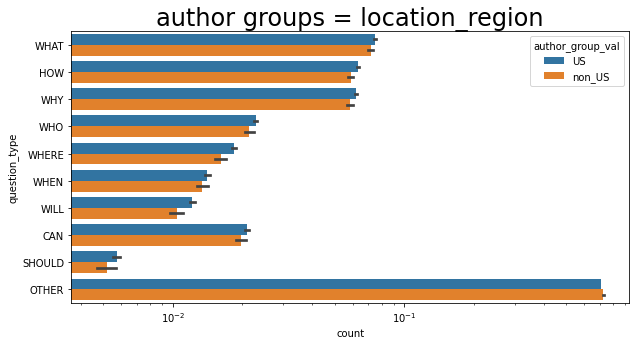

testing author group = prior_comment_count_bin


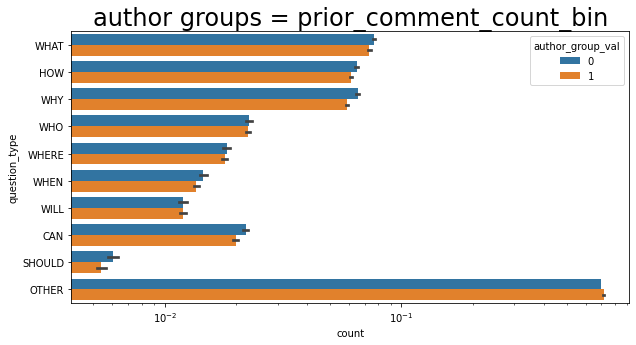

testing author group = prior_comment_len_bin


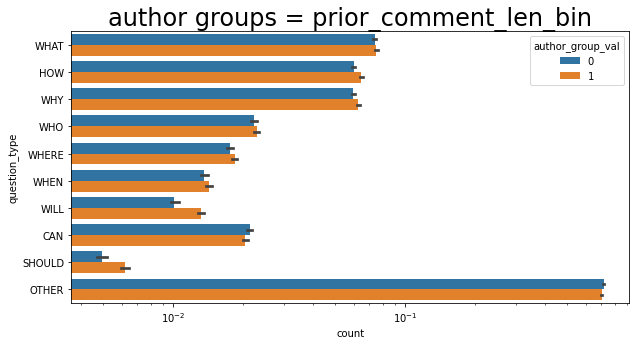

In [66]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for author_group_var_i, data_i in flat_question_type_count_data.groupby('author_group'):
    print(f'testing author group = {author_group_var_i}')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=data_i, y='question_type', x='count', hue='author_group_val', orient='h')
    plt.xscale('log')
    plt.title(f'author groups = {author_group_var_i}', fontsize=24)
    plt.show()

How many of these differences are significant?

In [79]:
from scipy.stats import norm
def two_sample_binom_test(data_1, data_2):
    p_1 = data_1.mean()
    p_2 = data_2.mean()
    N_1 = len(data_1)
    N_2 = len(data_2)
    p_pool = (N_1*p_1 + N_2*p_2) / (N_1 + N_2)
    z_stat = (p_1 - p_2) / (p_pool * (1-p_pool)*(1/N_1 + 1/N_2))**.5
    p_val = (1-norm.cdf(z_stat)) * 2.
    return z_stat, p_val

In [86]:
# p-val should correct for multiple hypotheses
p_val_thresh = 0.05 / len(question_types)
for author_group_var_i, data_i in flat_question_type_count_data.groupby('author_group'):
    group_vals = data_i.loc[:, 'author_group_val'].unique()
    group_val_1, group_val_2 = group_vals
    group_data_1 = data_i[data_i.loc[:, 'author_group_val']==group_val_1]
    group_data_2 = data_i[data_i.loc[:, 'author_group_val']==group_val_2]
    print(f'*~*~*~* testing author group var {author_group_var_i}: {group_val_1} vs. {group_val_2} *~*~*~*')
    for question_type_j in question_types:
        group_1_question_counts = group_data_1[group_data_1.loc[:, 'question_type']==question_type_j].loc[:, 'count']
        group_2_question_counts = group_data_2[group_data_2.loc[:, 'question_type']==question_type_j].loc[:, 'count']
        mean_diff = group_1_question_counts.mean() - group_2_question_counts.mean()
        test_stat, p_val = two_sample_binom_test(group_1_question_counts, group_2_question_counts)
#         print('diff = %.3f, test stat = %.3f (p=%.3E)'%(mean_diff, test_stat, p_val))
        if(p_val < p_val_thresh):
            print(f'group={author_group_var_i} has significant difference for question type={question_type_j}')
            print('diff = %.3f, test stat = %.3f (p=%.3E)'%(mean_diff, test_stat, p_val))

*~*~*~* testing author group var location_region: US vs. non_US *~*~*~*
group=location_region has significant difference for question type=WHAT
diff = 0.003, test stat = 3.495 (p=4.748E-04)
group=location_region has significant difference for question type=HOW
diff = 0.005, test stat = 5.237 (p=1.636E-07)
group=location_region has significant difference for question type=WHY
diff = 0.004, test stat = 4.084 (p=4.436E-05)
group=location_region has significant difference for question type=WHERE
diff = 0.002, test stat = 4.611 (p=4.004E-06)
group=location_region has significant difference for question type=WILL
diff = 0.002, test stat = 4.224 (p=2.399E-05)
*~*~*~* testing author group var prior_comment_count_bin: 0 vs. 1 *~*~*~*
group=prior_comment_count_bin has significant difference for question type=WHAT
diff = 0.003, test stat = 4.939 (p=7.858E-07)
group=prior_comment_count_bin has significant difference for question type=HOW
diff = 0.003, test stat = 5.491 (p=3.993E-08)
group=prior_co

OK! We see slight differences here.

- Location
    - US readers tend to ask more `WHAT`, `HOW`, `WHY`, `WHERE`, `WILL` questions than non-US readers.
- Prior comment counts
    - Readers who have previously written fewer comments less tend to ask more `WHAT`, `HOW`, `WHY`, `WHEN`, `CAN`, `SHOULD` questions than readers who have previously written more comments.
- Prior comment length
    - Readers who have previously written shorter comments tend to ask more `OTHER` questions than people who have previously written longer comments.

### Question semantic similarity
For the next test, we will convert all questions to their latent semantic representation and investigate how often people in the same reader group tend to ask semantically similar questions.

H1: The average similarity of questions among readers in group A is higher than the average similarity of questions between readers in group A and readers in group B.

In [1]:
# load data
## load comments
import os
import pandas as pd
month_year_pairs = [
        ('Jan', '2017'),
        ('Feb', '2017'),
        ('March', '2017'),
        ('April', '2017'),
        ('Jan', '2018'),
        ('Feb', '2018'),
        ('March', '2018'),
        ('April', '2018'),
    ]
comment_data_dir = '../../data/nyt_comments/'
comment_cols = ['articleID', 'commentBody', 'createDate', 'userID']
comment_data_files = list(map(lambda x: os.path.join(comment_data_dir, f'Comments{x[0]}{x[1]}.csv'), month_year_pairs))
comment_data = list(map(lambda x: pd.read_csv(x, sep=',', index_col=False, usecols=comment_cols), comment_data_files))
comment_data = pd.concat(comment_data, axis=0)
comment_data = comment_data.assign(**{
    'userID' : comment_data.loc[:, 'userID'].astype(int)
})
# remove null comments
comment_data = comment_data[comment_data.loc[:, 'commentBody'].apply(lambda x: type(x) is not float)]
# fix date var
from data_helpers import round_date_to_day
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(round_date_to_day)
})
display(comment_data.head())
## extract questions
from data_helpers import extract_questions
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
import re
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
min_question_len = 5
question_matcher = re.compile('.+\?$')
comment_data = comment_data.assign(**{
    'comment_questions' : comment_data.loc[:, 'commentBody'].apply(lambda x: extract_questions(x, word_tokenizer, sent_tokenizer, question_matcher, min_question_len=min_question_len))
})
## get author social data
import pandas as pd
from datetime import datetime
comment_author_data = pd.read_csv('../../data/nyt_comments/author_comment_social_data.tsv', sep='\t', index_col=False)
date_day_fmt = '%Y-%m-%d'
comment_author_data = comment_author_data.assign(**{
    'date_day' : comment_author_data.loc[:, 'date_day'].apply(lambda x: datetime.strptime(x, date_day_fmt))
})
display(comment_author_data.head())
## join data
combined_comment_author_data = pd.merge(comment_author_data, comment_data, on=['userID', 'date_day'])
print(f'{combined_comment_author_data.shape[0]} comments')
display(combined_comment_author_data.head())
## flatten data
question_author_data = []
for idx_i, data_i in combined_comment_author_data.iterrows():
    for question_j in data_i.loc['comment_questions']:
        data_j = data_i.copy()
        data_j.loc['question'] = question_j
        question_author_data.append(data_j)
question_author_data = pd.concat(question_author_data, axis=1).transpose()

<ipython-input-1-286de00382d4>:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


,articleID,commentBody,createDate,userID,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,1.483426e+09,64679318,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,1.483417e+09,69254188,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,1.483431e+09,76788711,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,1.483419e+09,72718862,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,1.483417e+09,7529267,2017-01-02


,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region
0,1045,2017-04-09,1,0,US
1,1045,2018-01-17,0,0,US
2,1045,2018-01-24,0,0,US
3,1072,2017-03-13,1,1,US
4,1072,2018-01-03,0,1,US


1899592 comments


,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,comment_questions
0,1045,2017-04-09,1,0,US,58e3609a7c459f24986d83a6,"The ""earliest days of the internet"" were not i...",1.491756e+09,[]
1,1045,2018-01-17,0,0,US,5a5f71d87c459f29e79b46ad,You left out the part where she wrote an anony...,1.516227e+09,"[Is that the right thing, too?]"
2,1045,2018-01-24,0,0,US,5a68592710f40f00018bd70d,"Yes, thank you. Folks need to lighten up. I wo...",1.516816e+09,[]
3,1072,2017-03-13,1,1,US,58c7001c7c459f247805b940,“Try to imagine a … presidential candidate say...,1.489449e+09,[]
4,1072,2018-01-03,0,1,US,5a4e75be7c459f29e79b20c2,Fix the Subways. That this argument has to be...,1.514982e+09,[]


In [5]:
display(question_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,comment_questions,question
1,1045,2018-01-17,0,0,US,5a5f71d87c459f29e79b46ad,You left out the part where she wrote an anony...,1.51623e+09,"[Is that the right thing, too?]","Is that the right thing, too?"
5,1072,2018-01-04,0,1,US,5a4e81e87c459f29e79b2533,Sometimes being right can be pretty horrible a...,1.51512e+09,[Sometimes being right can be pretty horrible ...,Sometimes being right can be pretty horrible a...
16,1166,2017-01-25,1,0,US,5888c98295d0e0392607cb61,Where did you learn English?,1.48539e+09,[Where did you learn English?],Where did you learn English?
21,1166,2017-01-29,1,0,US,588e0b1e95d0e0392607d69a,How long before elements of the military and t...,1.48574e+09,[How long before elements of the military and ...,How long before elements of the military and t...
40,1166,2017-02-26,1,0,US,58b2d20b95d0e02474638a43,"You really don't know that the NBA, NFL, MLB a...",1.48815e+09,"[You really don't know that the NBA, NFL, MLB ...","You really don't know that the NBA, NFL, MLB a..."


In [77]:
## encode questions => BERT
## tokenize, encode all text
def tokenize_encode_text(text, model, tokenizer, device):
    text_token_ids = tokenizer(text, return_tensors='pt')
    if(device != 'cpu'):
        text_token_ids = text_token_ids.to(device)
    last_hidden_state, decoder_hidden_states = model(**text_token_ids)
    # get final hidden state
    hidden_state_0 = last_hidden_state[:, -1, :].squeeze().cpu().detach().numpy()
#     print(f'hidden state = {hidden_state_0}')
    # return to CPU to prevent CUDA memory overload
    text_token_ids = text_token_ids.to('cpu')
    return hidden_state_0

In [29]:
from transformers import AutoModelForSeq2SeqLM
from transformers import BartModel
import torch
model_cache_dir = '../../data/nyt_comments/model_cache/'
# generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=model_cache_dir)
model = BartModel.from_pretrained('facebook/bart-base', cache_dir=model_cache_dir)
tokenizer = torch.load('../../data/CNN_articles/cnn/BART_tokenizer.pt')

In [66]:
test_outputs = []
test_sents = ['this is a test sentence', 'this is another test sentence', 'this is a test sandwich', 'penguins often eat fish by the ocean']
for test_sent in test_sents:
    test_input = tokenizer(test_sent, return_tensors='pt')
    test_output = model(**test_input)
    test_outputs.append(test_output[0][:, -1, :].squeeze().detach().numpy())
# compute similarity
from sklearn.metrics.pairwise import cosine_similarity
test_outputs = np.vstack(test_outputs)
test_output_dist = cosine_similarity(test_outputs)
print(test_output_dist)

[[1.0000002  0.9815428  0.8939376  0.66279364]
 [0.9815428  1.0000001  0.88226134 0.65044063]
 [0.8939376  0.88226134 1.0000002  0.7162157 ]
 [0.66279364 0.65044063 0.7162157  1.0000001 ]]


OK! Sanity check complete, the similar sentences are indeed counted as similar.

In [72]:
## test question encoding
q_1 = question_author_data.loc[:, 'question'].iloc[0]
q_2 = question_author_data.loc[:, 'question'].iloc[1]
print(q_1)
print(q_2)
q_enc_1 = tokenize_encode_text(q_1, model, tokenizer, 'cpu')
q_enc_2 = tokenize_encode_text(q_2, model, tokenizer, 'cpu')
print(q_enc_1 - q_enc_2)

Is that the right thing, too?
Sometimes being right can be pretty horrible and wrong huh?
[ 1.45465806e-01 -6.05827153e-01 -3.83809566e-01  1.87804699e-01
 -5.09216905e-01  8.46210539e-01 -1.88082486e-01  4.57356304e-01
  1.46403790e+00 -6.55469894e-02  3.98349285e-01  3.10435891e-01
 -6.19446635e-01 -6.39954433e-02 -5.90215445e-01 -1.45802081e-01
 -1.29417992e+00  2.44788408e-01 -2.78814882e-01 -2.06020713e-01
 -1.70863080e+00 -7.29737043e-01  1.11317003e+00 -9.23060894e-01
 -7.38027990e-01 -4.09304321e-01 -2.16623098e-01  1.58599043e+00
 -2.83897257e+00  2.84485817e-01 -6.66565150e-02  1.10561609e+00
 -7.88607717e-01 -6.23191833e-01  5.96344471e-01  4.29870605e-01
 -1.60297275e-01  1.67950630e+00 -3.26487601e-01 -1.21006560e+00
  5.38176537e-01 -2.75922775e+00 -1.06017828e-01 -1.83483267e+00
 -1.22445214e+00 -4.27012414e-01 -1.14033318e+00 -1.03710747e+00
 -2.19013095e-02  2.10832453e+00 -1.16401815e+00  9.61285591e-01
  7.84167051e-01 -9.68095958e-02 -1.51921391e-01 -5.81848979e-01


In [78]:
from tqdm import tqdm
tqdm.pandas()
device_name = 'cuda:1'
device = torch.device(device_name)
model.to(device)
torch.cuda.empty_cache()
with torch.no_grad():
    generation_model.eval()
    question_embeddings = question_author_data.loc[:, 'question'].progress_apply(lambda x: tokenize_encode_text(x, model, tokenizer, device))
    torch.cuda.empty_cache()

 60%|██████    | 373538/618257 [1:34:27<1:15:09, 54.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 458282/618257 [1:56:05<47:24, 56.23it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 543983/618257 [2:18:12<17:40, 70.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

In [ ]:
# ## save data to file to release GPU use
# torch.cuda.empty_cache()
# # del(model)
# question_embeddings_matrix = np.vstack(question_embeddings)
print(question_embeddings_matrix.shape)
np.savez_compressed('../../data/nyt_comments/author_comment_data_questions_embeds.npz', question_embeddings_matrix)

In [2]:
import numpy as np
question_embeddings_matrix_data = np.load('../../data/nyt_comments/author_comment_data_questions_embeds.npz')
question_embeddings_matrix = list(question_embeddings_matrix_data.items())[0][1]

Now that we've computed the embeddings for all questions, let's look at similarity among readers of the same group and differences among readers of different groups.

In [17]:
%%timeit
a = np.random.randn(10,10)
b = a[0, :]
c = cosine_similarity(a, b.reshape(1,-1))
# print(c)

189 µs ± 874 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit
a = np.random.randn(10,10)
b = a[0, :]
for i in range(a.shape[0]):
    c = cosine(a[i, :], b)

5.73 ms ± 61.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import numpy as np
np.random.seed(123)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import cosine
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
def compute_self_sim(embeddings, idx):
    sims = []
    for i, idx_i in tqdm(enumerate(idx)):
        embed_i = embeddings[idx_i, :].reshape(1,-1)
        sims_i = cosine_similarity(embed_i, embeddings[(i+1):, :])
        for j in range(sims_i.shape[0]):
            sims.append(sims_i[j, :])
#         for idx_j in enumerate(idx[(i+1):]):
#             sim_i_j = cosine(embeddings[idx_i, :], embeddings[idx_j, :])
#             sims.append(sim_i_j)
    return sims
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
sample_size = 1000
sample_article_ids = np.random.choice(question_author_data.loc[:, 'articleID'].unique(), sample_size, replace=False)
for author_group_var in author_group_vars:
    # assume 2 group vals per variable
    author_group_vals = question_author_data.loc[:, author_group_var].unique()
    author_group_val_1, author_group_val_2 = author_group_vals
    author_group_1_idx = np.where((question_author_data.loc[:, author_group_var]==author_group_val_1) & 
                                  (question_author_data.loc[:, 'articleID'].isin(sample_article_ids)))[0]
    author_group_2_idx = np.where((question_author_data.loc[:, author_group_var]==author_group_val_2) & 
                                  (question_author_data.loc[:, 'articleID'].isin(sample_article_ids)))[0]
    author_group_1_idx = np.random.choice(author_group_1_idx, sample_size, replace=False)
    author_group_2_idx = np.random.choice(author_group_2_idx, sample_size, replace=False)
    # get sample data, otherwise this will get ugly
#     author_group_1_idx = np.random.choice(author_group_1_idx, sample_size, replace=False)
#     author_group_2_idx = np.random.choice(author_group_2_idx, sample_size, replace=False)
#     author_group_1_embeddings = question_embeddings_matrix[author_group_1_idx, :]
#     author_group_2_embeddings = question_embeddings_matrix[author_group_2_idx, :]
    ## compute within-group similarity
    # DO NOT DO THIS it blows up the memory
#     group_1_sim = cosine_similarity(author_group_1_embeddings)
#     group_2_sim = cosine_similarity(author_group_2_embeddings)
    # only keep values above diagonal
    N_1 = len(author_group_1_idx)
    N_2 = len(author_group_2_idx)
    group_1_sim = compute_self_sim(question_embeddings_matrix, author_group_1_idx)
    group_2_sim = compute_self_sim(question_embeddings_matrix, author_group_2_idx)
#     group_1_sim = np.array([cosine(question_embeddings_matrix[author_group_1_idx[i]], question_embeddings_matrix[author_group_1_idx[j]]) for i in range(N_1) for j in range(i+1,N_1)])
#     group_2_sim = np.array([cosine(question_embeddings_matrix[author_group_2_idx[i]], question_embeddings_matrix[author_group_2_idx[j]]) for i in range(N_1) for j in range(i+1,N_1)])
    ## compute across-group similarity
#     group_1_2_sim = cosine_similarity(author_group_1_embeddings, author_group_2_embeddings).reshape(1,-1)[0]
    group_1_2_sim = []
    for i in tqdm(author_group_1_idx):
        sims_i = cosine_similarity(question_embeddings_matrix[i, :].reshape(1,-1), 
                                   question_embeddings_matrix[author_group_2_idx, :])
        for j in range(len(sims_i)):
            group_1_2_sim.append(sims_i[j, :])
#     group_1_2_sim = np.array([cosine(question_embeddings_matrix[i, :], question_embeddings_matrix[j, :]) for i in author_group_1_idx for j in author_group_2_idx])
    ## plot all similarity scores
    sim_scores_combined = pd.DataFrame({
        'sim_score' : np.vstack(group_1_sim, group_2_sim, group_1_2_sim),
        'sim_score_group' : np.array([author_group_val_1,]*len(group_1_sim) + 
                                     [author_group_val_2,]*len(group_2_sim) + 
                                     [f'{author_group_val_1}*{author_group_val_2}',]*(group_1_2_sim.shape[0]))
    })
    sns.barplot(x='sim_score_group', y='sim_score', data=sim_scores_combined)
    plt.legend(loc='lower right')
    plt.show()
    break

In [1]:
print('blah')

blah
